In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as tc
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
class Morphism(nn.Module):
    def __init__ (self, name = 'Morphisme R^n --> E', dim_E = 1, neurons = 6):
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(Morphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)

        # dropout layer
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [3]:
class InverseMorphism(nn.Module):
    def __init__ (self, name = 'Inverse E --> R^n', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(InverseMorphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3= nn.Linear(neurons, neurons)
        
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [4]:
class LoiBinaire(nn.Module):
    def __init__ (self, name = 'Loi binaire ExE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiBinaire, self).__init__()
        # layers for plus : ExE --> E
        self.fc1 = nn.Linear(2 * dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x, y):
        z = torch.cat([x,y], axis=1) # [K,d], [K,d] ---> [K, 2*d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output
# scalaire product of structure

In [5]:
class LoiScalaire(nn.Module):
    def __init__ (self, name = 'Loi Scalaire RxE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiScalaire, self).__init__()
        # layers for scaler : KxE --> E
        

        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
        
        # alpha est un  scalaire,  dim_E est la dimension de l'espace E
        
    def forward(self, alpha, x):
        z = alpha * x # [K,1], [K,d] ---> [K, d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output

In [6]:
class Vect_space(nn.Module):
    def __init__ (self, K,  dim_E = 1 , neurons = 6 , name = 'Groupe (E,+)'):
        super(Vect_space, self).__init__()
        self.f    = Morphism(dim_E = dim_E, neurons = neurons)
        self.fi   = InverseMorphism(dim_E = dim_E, neurons = neurons)
        self.plus = LoiBinaire(dim_E = dim_E, neurons = neurons)
        self.scalaire = LoiScalaire(dim_E = dim_E, neurons = neurons)
        # losses
        self.loss_1 = lambda x, y : torch.linalg.vector_norm(self.plus(x , y) - self.f( self.fi(x) + self.fi(y)) )**2
        self.loss_2 = lambda alpha, x : torch.linalg.vector_norm(self.scalaire(alpha , x) - self.f( alpha*self.fi(x)) )**2

        #  Total loss can be weighted 
        self.loss = lambda x, y, alpha : self.loss_1(x, y) + self.loss_2(alpha, x)
        
    def train(self, X, Y,alpha, optimizer, epoch):
        self.f.train()
        self.fi.train()
        self.plus.train()
        self.scalaire.train()
        losses=[]
        for i in range(epoch):
            L1 = self.loss_1(X, Y)
            L2 = self.loss_2(alpha, X)
            loss = L1 + L2
            #loss = loss.mean()
            if i % 200 == 0:
               print('Epoch {}/{} -\t Loss 1: {:.6f}\t Loss 2: {:.6f}\t Total Loss: {:.6f}'.format(i, epoch, L1.item(), L2.item(), loss.item()))
            
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        return losses

In [7]:
def line(K, epsilon):
    X = torch.rand(K, 2).requires_grad_(False)
    X[K//2:] *= -1
    Y = torch.randn(K, 2).requires_grad_(False)
    Y[K//2:] *= -1
    alpha = torch.randn(K, 1).requires_grad_(False)
    X[:,1] = X[:,0] + epsilon * torch.sin(X[:,0] / epsilon)
    Y[:,1] = Y[:,0] + epsilon * torch.sin(Y[:,0] / epsilon)
    return X, Y, alpha

[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 60.503082	 Loss 2: 72.168861	 Total Loss: 132.671936
Epoch 200/1000 -	 Loss 1: 4.149027	 Loss 2: 4.895600	 Total Loss: 9.044626
Epoch 400/1000 -	 Loss 1: 0.019128	 Loss 2: 0.114746	 Total Loss: 0.133873
Epoch 600/1000 -	 Loss 1: 0.012362	 Loss 2: 0.017766	 Total Loss: 0.030128
Epoch 800/1000 -	 Loss 1: 0.011526	 Loss 2: 0.012267	 Total Loss: 0.023793


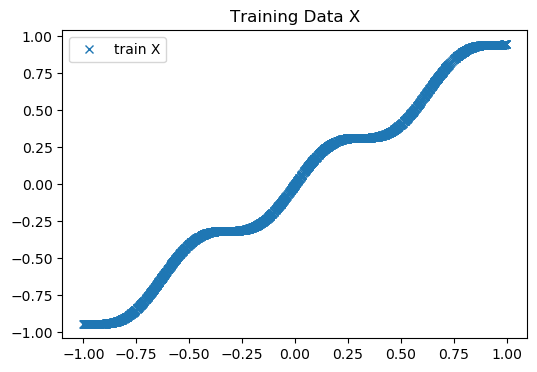

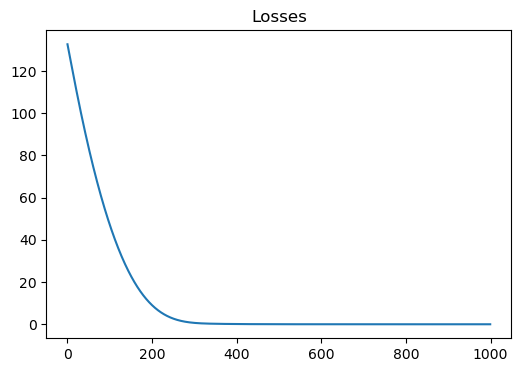

In [8]:
K = 2000
epislon = 0.1
X,Y,alpha = line(K, epislon)
dim = 2

# on initialise le vecteur space
G = Vect_space(K, dim_E = dim, neurons = 64)
# on initialise l'optimiseur

optimizer = optim.Adadelta(list(G.parameters()), lr=1e-3)
# la loss
losses = G.train(X,Y, alpha, optimizer, 1000)

plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'x', label='train X')
plt.title('Training Data X')
plt.legend()
plt.show()



# on affiche la loss 
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title('Losses')
plt.show()

In [9]:
K = 10
B = 0.3*torch.randn((K, 2))
C = 0.3*torch.randn((K, 2))
alpha = torch.randn((K, 1))

# Générer une valeur aléatoire pour B[0,0]
for i in range(K):
    B[i,1] = B[i,0] + epislon * torch.sin(B[i,0] / epislon )
    C[i,1] = C[i,0] + epislon * torch.sin(C[i,0] / epislon )



    
print(B)

print(C)


tensor([[ 0.0719,  0.1378],
        [-0.0647, -0.1250],
        [ 0.3269,  0.3142],
        [ 0.0022,  0.0045],
        [-0.0993, -0.1831],
        [-0.0634, -0.1226],
        [-0.0890, -0.1667],
        [ 0.3097,  0.3142],
        [-0.0456, -0.0897],
        [ 0.1705,  0.2696]])
tensor([[ 0.0024,  0.0048],
        [-0.2616, -0.3118],
        [ 0.1027,  0.1883],
        [ 0.2623,  0.3119],
        [ 0.0296,  0.0588],
        [-0.1094, -0.1982],
        [-0.2718, -0.3129],
        [-0.1969, -0.2891],
        [-0.1708, -0.2699],
        [-0.3826, -0.3194]])


In [10]:
import pandas as pd
# Convert B and C to numpy arrays
# Convert B and C to numpy arrays
B_np = B.numpy()
C_np = C.numpy()
alpha_np = alpha.numpy()

# Create a DataFrame
df = pd.DataFrame({
    'B_x': B_np[:, 0],
    'B_y': B_np[:, 1],
    'C_x': C_np[:, 0],
    'C_y': C_np[:, 1],
    'alpha': alpha_np[:, 0]
})

print(df)



        B_x       B_y       C_x       C_y     alpha
0  0.071934  0.137823  0.002415  0.004829 -0.824309
1 -0.064732 -0.125037 -0.261576 -0.311769 -0.338598
2  0.326947  0.314194  0.102743  0.188340  2.216040
3  0.002241  0.004483  0.262321  0.311869  0.013124
4 -0.099308 -0.183079  0.029635  0.058838  1.505399
5 -0.063366 -0.122576 -0.109394 -0.198239  1.471538
6 -0.088967 -0.166653 -0.271766 -0.312901 -0.454786
7  0.309713  0.314158 -0.196866 -0.289055 -0.300827
8 -0.045611 -0.089658 -0.170811 -0.269870  0.190826
9  0.170513  0.269612 -0.382593 -0.319377 -0.049390


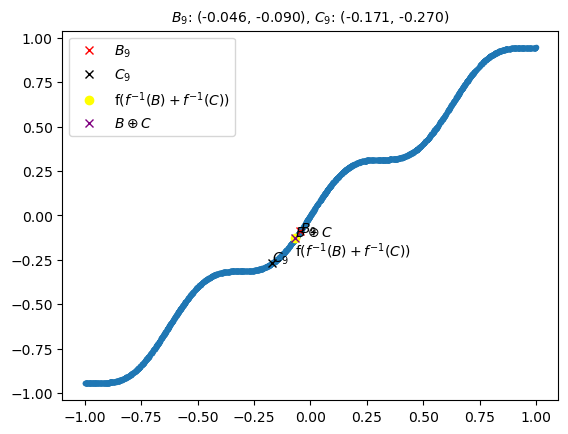

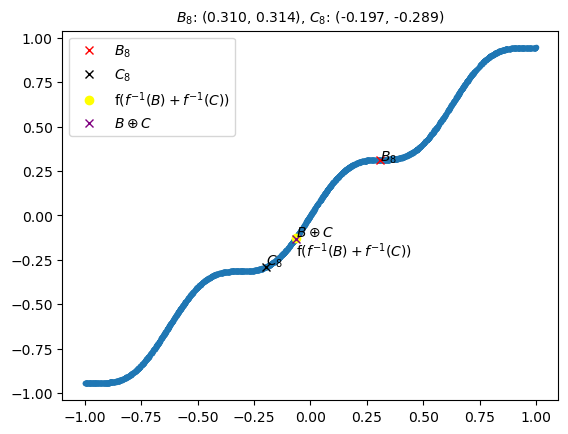

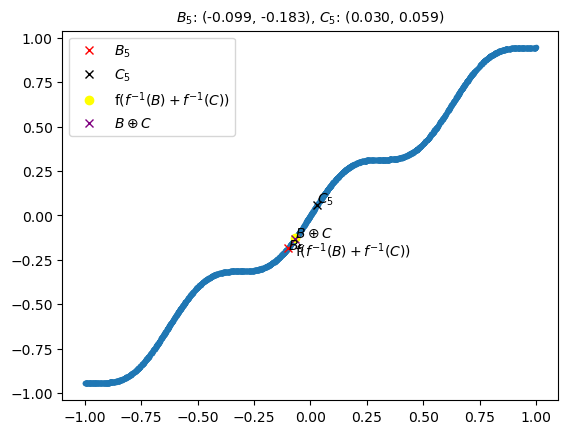

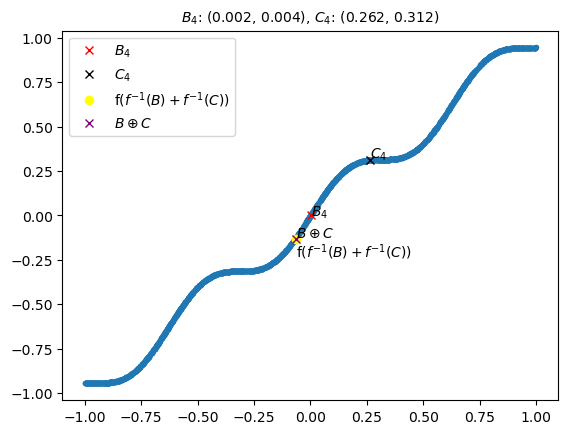

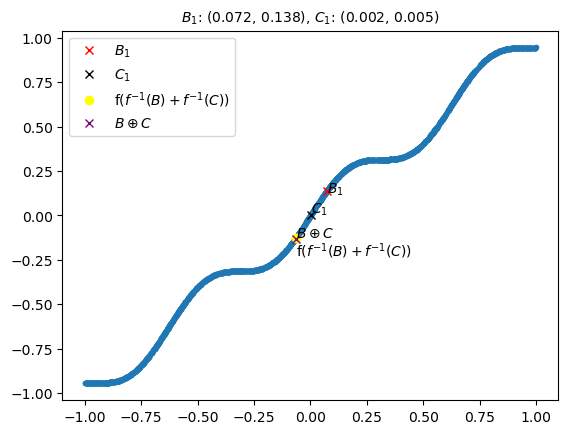

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm

XXBC =  G.f(G.fi(B) + G.fi(C))
YYBC = G.plus(B, C)

# indice = random.sample(range(B.shape[0]),5)
# for i in indice:
#     plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], color='blue', alpha =  0.05) 
#     plt.scatter(B[i, 0], B[i, 1], color='red', label=f'B_{i+1}')  
#     plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1] - 0.01))
#     plt.scatter(C[i, 0], C[i, 1], color='green', label=f'C_{i+1}')
#     plt.annotate(f'C_{i+1}', (C[i, 0], C[i, 1] + 0.01))
#     # Tracer le point XXBC[i]
#     plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='orange', label=f'f(fi(B) + fi(C))')
#     plt.annotate(f'f(fi(B) + fi(C))', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

#     # Tracer le point YYBC[i]
#     plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='pink', label=f'B⊕C')
#     plt.annotate(f'B⊕C', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
#     # Ajouter une légende au subplot
#     plt.legend()
#     plt.show()



indice = random.sample(range(B.shape[0]),5)
for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=r'$B_{' + str(i+1) + '}$')  
    plt.annotate(r'$B_{' + str(i+1) + '}$', (B[i, 0], B[i, 1] - 0.01))
    plt.plot(C[i, 0], C[i, 1], 'x',  color='black', label=r'$C_{' + str(i+1) + '}$', )
    plt.annotate(r'$C_{' + str(i+1) + '}$', (C[i, 0], C[i, 1] + 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($f^{-1}(B) + f^{-1}(C)$)')
    plt.annotate(r'f($f^{-1}(B) + f^{-1}(C)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$B \oplus C$')
    plt.annotate(r'$B \oplus C$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    

    plt.title(r'$B_{' + str(i+1) + '}$' + f': ({B[i, 0]:.3f}, {B[i, 1]:.3f}), ' + r'$C_{' + str(i+1) + '}$' + f': ({C[i, 0]:.3f}, {C[i, 1]:.3f})', fontsize=10)
    plt.legend()
    plt.show()

In [12]:
XXBC =  G.f(G.fi(B) + G.fi(C))

YYBC = G.plus(B, C)

# print(XXBC)
# print(YYBC)


XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f.fi(B) + f.fi(C)'] = XXBC_list
df['B⊕C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf

df






,B_x,B_y,C_x,C_y,alpha,f.fi(B) + f.fi(C),B⊕C,L^2 erreur,inf erreur
0,0.071934,0.137823,0.002415,0.004829,-0.824309,"[-0.06613078, -0.12944034]","[-0.06552997, -0.13130972]",2.0e-03,1.9e-03
1,-0.064732,-0.125037,-0.261576,-0.311769,-0.338598,"[-0.06851723, -0.12644732]","[-0.06862322, -0.12829709]",1.9e-03,1.8e-03
2,0.326947,0.314194,0.102743,0.188340,2.216040,"[-0.064494245, -0.13142805]","[-0.06394292, -0.13486241]",3.5e-03,3.4e-03
3,0.002241,0.004483,0.262321,0.311869,0.013124,"[-0.0653138, -0.13042235]","[-0.06469125, -0.13328388]",2.9e-03,2.9e-03
4,-0.099308,-0.183079,0.029635,0.058838,1.505399,"[-0.0671712, -0.12811075]","[-0.0670244, -0.1311281]",3.0e-03,3.0e-03
5,-0.063366,-0.122576,-0.109394,-0.198239,1.471538,"[-0.06793319, -0.12713516]","[-0.06803832, -0.1285573]",1.4e-03,1.4e-03
6,-0.088967,-0.166653,-0.271766,-0.312901,-0.454786,"[-0.068700336, -0.12622061]","[-0.06885295, -0.12827022]",2.1e-03,2.0e-03
7,0.309713,0.314158,-0.196866,-0.289055,-0.300827,"[-0.06644125, -0.12897809]","[-0.06638687, -0.1300772]",1.1e-03,1.1e-03
8,-0.045611,-0.089658,-0.170811,-0.269870,0.190826,"[-0.06811708, -0.12691475]","[-0.068224944, -0.12811324]",1.2e-03,1.2e-03
9,0.170513,0.269612,-0.382593,-0.319377,-0.049390,"[-0.067145616, -0.1282609]","[-0.06650417, -0.13058828]",2.4e-03,2.3e-03


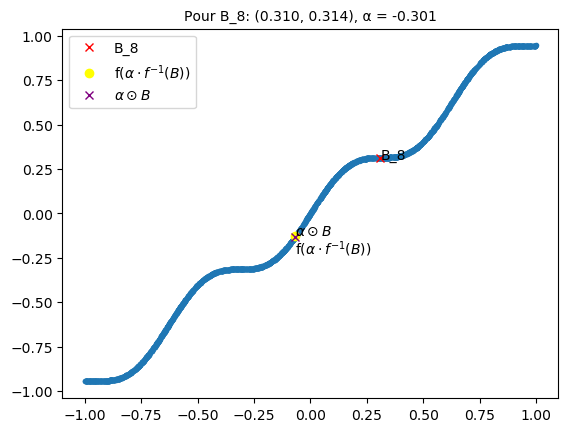

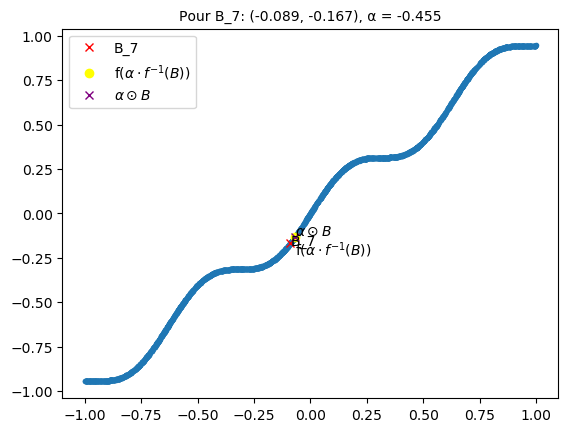

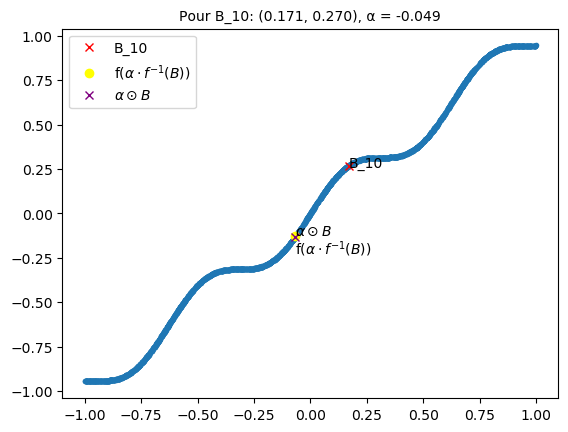

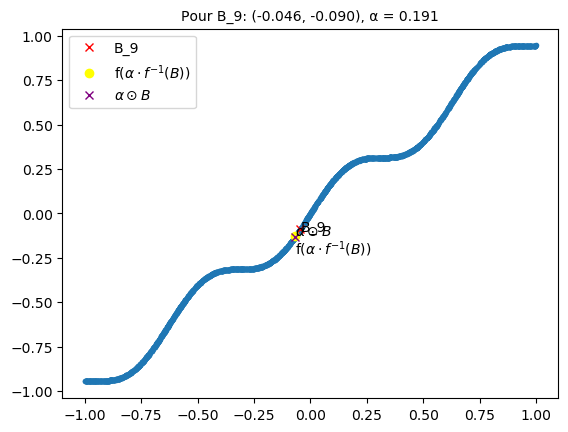

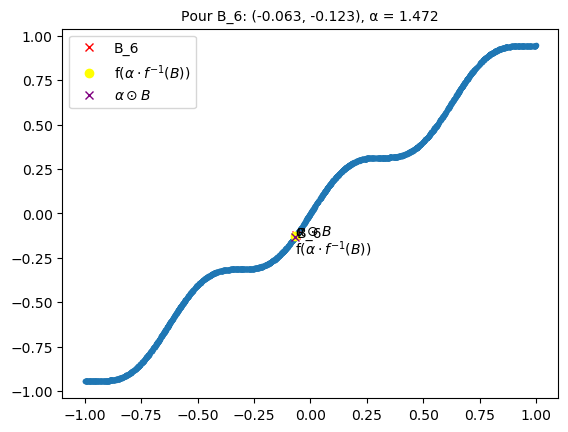

In [13]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

XXBC =  G.f(alpha * G.fi(B))

YYBC = G.scalaire(alpha, B)
indice = random.sample(range(B.shape[0]),5)
# for i in indice:
#     plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], color='blue', label='X') 
#     plt.scatter(B[i, 0], B[i, 1], color='red', label=f'B_{i+1}')  
#     plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1]))
#     plt.scatter(C[i, 0], C[i, 1], color='green', label=f'C_{i+1}')
#     plt.annotate(f'C_{i+1}', (C[i, 0], C[i, 1]))
#     # Tracer le point XXBC[i]
#     plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='orange', label=f'f(alpha * fi(B)')
#     plt.annotate(f'f( alpha * fi(B))', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy()))

#     # Tracer le point YYBC[i]
#     plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='pink', label=f'B⊕C')
#     plt.annotate(f'B⊕C', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy()))
#     # Ajouter une légende au subplot
#     plt.legend()
#     plt.show()





for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=f'B_{i+1}')  
    plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1] - 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($\alpha \cdot f^{-1}(B)$)')
    plt.annotate(r'f($\alpha \cdot f^{-1}(B)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$\alpha \odot B$')
    plt.annotate(r'$\alpha \odot B$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    
    plt.title(f'Pour B_{i+1}: ({B[i, 0].item():.3f}, {B[i, 1].item():.3f}), α = {alpha[i].item():.3f}', fontsize=10)
    plt.legend()
    plt.show()

In [14]:
XXBC =  G.f(alpha *G.fi(B))

YYBC = G.scalaire(alpha, B)

# print(XXBC)
# print(YYBC)


XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f(alpha . fi(B))'] = XXBC_list
df['B⊙C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf

df






,B_x,B_y,C_x,C_y,alpha,f.fi(B) + f.fi(C),B⊕C,L^2 erreur,inf erreur,f(alpha . fi(B)),B⊙C
0,0.071934,0.137823,0.002415,0.004829,-0.824309,"[-0.06613078, -0.12944034]","[-0.06552997, -0.13130972]",2.4e-03,2.4e-03,"[-0.068256035, -0.1293884]","[-0.068011075, -0.13178098]"
1,-0.064732,-0.125037,-0.261576,-0.311769,-0.338598,"[-0.06851723, -0.12644732]","[-0.06862322, -0.12829709]",2.6e-03,2.6e-03,"[-0.067457534, -0.12995207]","[-0.067416325, -0.13252145]"
2,0.326947,0.314194,0.102743,0.188340,2.216040,"[-0.064494245, -0.13142805]","[-0.06394292, -0.13486241]",4.1e-03,4.1e-03,"[-0.06337649, -0.13253006]","[-0.06421892, -0.13659085]"
3,0.002241,0.004483,0.262321,0.311869,0.013124,"[-0.0653138, -0.13042235]","[-0.06469125, -0.13328388]",2.7e-03,2.7e-03,"[-0.06747993, -0.12959076]","[-0.06757735, -0.13232106]"
4,-0.099308,-0.183079,0.029635,0.058838,1.505399,"[-0.0671712, -0.12811075]","[-0.0670244, -0.1311281]",3.5e-03,3.4e-03,"[-0.067957014, -0.12757248]","[-0.06864022, -0.13099618]"
5,-0.063366,-0.122576,-0.109394,-0.198239,1.471538,"[-0.06793319, -0.12713516]","[-0.06803832, -0.1285573]",3.5e-03,3.4e-03,"[-0.06759232, -0.12806737]","[-0.06826408, -0.13146614]"
6,-0.088967,-0.166653,-0.271766,-0.312901,-0.454786,"[-0.068700336, -0.12622061]","[-0.06885295, -0.12827022]",2.5e-03,2.5e-03,"[-0.06737303, -0.13016948]","[-0.067286566, -0.13268332]"
7,0.309713,0.314158,-0.196866,-0.289055,-0.300827,"[-0.06644125, -0.12897809]","[-0.06638687, -0.1300772]",2.6e-03,2.6e-03,"[-0.068035655, -0.12920421]","[-0.06802338, -0.13175495]"
8,-0.045611,-0.089658,-0.170811,-0.269870,0.190826,"[-0.06811708, -0.12691475]","[-0.068224944, -0.12811324]",2.8e-03,2.8e-03,"[-0.06747478, -0.12942919]","[-0.06764242, -0.13224009]"
9,0.170513,0.269612,-0.382593,-0.319377,-0.049390,"[-0.067145616, -0.1282609]","[-0.06650417, -0.13058828]",2.7e-03,2.7e-03,"[-0.067558914, -0.12954964]","[-0.067631215, -0.13225359]"


In [15]:
frame = df[['B_x', 'B_y', 'L^2 erreur', 'inf erreur', 'B⊙C', 'f(alpha . fi(B))']]


frame = df[['B_x', 'B_y', 'B⊙C', 'f(alpha . fi(B))', 'L^2 erreur', 'inf erreur']]

frame


,B_x,B_y,B⊙C,f(alpha . fi(B)),L^2 erreur,inf erreur
0,0.071934,0.137823,"[-0.068011075, -0.13178098]","[-0.068256035, -0.1293884]",2.4e-03,2.4e-03
1,-0.064732,-0.125037,"[-0.067416325, -0.13252145]","[-0.067457534, -0.12995207]",2.6e-03,2.6e-03
2,0.326947,0.314194,"[-0.06421892, -0.13659085]","[-0.06337649, -0.13253006]",4.1e-03,4.1e-03
3,0.002241,0.004483,"[-0.06757735, -0.13232106]","[-0.06747993, -0.12959076]",2.7e-03,2.7e-03
4,-0.099308,-0.183079,"[-0.06864022, -0.13099618]","[-0.067957014, -0.12757248]",3.5e-03,3.4e-03
5,-0.063366,-0.122576,"[-0.06826408, -0.13146614]","[-0.06759232, -0.12806737]",3.5e-03,3.4e-03
6,-0.088967,-0.166653,"[-0.067286566, -0.13268332]","[-0.06737303, -0.13016948]",2.5e-03,2.5e-03
7,0.309713,0.314158,"[-0.06802338, -0.13175495]","[-0.068035655, -0.12920421]",2.6e-03,2.6e-03
8,-0.045611,-0.089658,"[-0.06764242, -0.13224009]","[-0.06747478, -0.12942919]",2.8e-03,2.8e-03
9,0.170513,0.269612,"[-0.067631215, -0.13225359]","[-0.067558914, -0.12954964]",2.7e-03,2.7e-03
